In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import langevin
from scipy.stats import pearsonr
from scipy.optimize import root

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#SEED = 35010732 # from random.org
#np.random.seed(SEED)

print(plt.style.available)
plt.style.use('seaborn-white')

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [9]:
def correlated_ts(c,delta_t = 0.1,N=1000):
    # parameters for coupled oscillator
    K,D = 1.0,1.0
    data1 = langevin.time_series(A=1/K, D=D, delta_t=delta_t, N=N)
    data2 = langevin.time_series(A=1/(K+np.abs(c)), D=D, delta_t=delta_t, N=N)
    x1 = (data1 + data2)/2
    if c>0:
        x2 = (data1 - data2)/2
    else:
        x2 = (data2-data1)/2

    return x1,x2

def c_rho(rho):
    return 2*np.abs(rho)/(1-np.abs(rho))*np.sign(rho)


In [10]:
def calc_fundstats(x):
    return x[0]**2+x[-1]**2,np.sum(x[1:-1]**2),np.sum(x[0:-1]*x[1:])

In [11]:
def b(D,A,delta_t):
    return np.exp(-D/A*delta_t)

def q(aep,ass,ac,b):
    return (aep + (1+b**2)*ass - 2*b*ac)/(1-b**2)

def dqdB(aep,ass,ac,b):
    return 2*(b*aep+2*b*ass-(1+b**2)*ac)/(1-b**2)**2

def d2qdB2(aep,ass,ac,b):
    return (6*b+2)/(1-b**2)**3*(aep+2*ass)-(4*b**3+12*b)/(1-b**2)**3*ac

def dBdA(b,D,A,delta_t):
    return b*D*delta_t/A**2

def dBdD(b,A,delta_t):
    return -b*delta_t/A

def d2BdA2(b,D,A,delta_t):
    return b*D*delta_t/A**3*(D*delta_t/A-2)

def d2BdD2(b,A,delta_t):
    return b*delta_t**2/A**2

def d2BdAdD(b,D,A,delta_t):
    return b*delta_t/A**2*(1-D*delta_t/A)

def d2qdD2(aep,ass,ac,b,A,delta_t):
    return d2qdB2(aep,ass,ac,b)*dBdD(b,A,delta_t)**2+dqdB(aep,ass,ac,b)*d2BdD2(b,A,delta_t)

def d2qdA2(aep,ass,ac,b,D,A,delta_t):
    return d2qdB2(aep,ass,ac,b)*dBdA(b,D,A,delta_t)**2+dqdB(aep,ass,ac,b)*d2BdA2(b,D,A,delta_t)

def d2qdAdD(aep,ass,ac,b,D,A,delta_t):
    return d2qdB2(aep,ass,ac,b)*dBdA(b,D,A,delta_t)*dBdD(b,A,delta_t)+dqdB(aep,ass,ac,b)*d2BdAdD(b,D,A,delta_t)

#def d2PdA2(N,aep,ass,ac,b,D,A,delta_t):
#    return (N/2/A**2 - 
#            q(aep,ass,ac,b)/A**3 +
#            (N-1)/(1-b**2)*(b*d2BdA2(b,D,A,delta_t) + dBdA(b,D,A,delta_t)**2*(1+b**2)/(1-b**2)) -
#            d2qdA2(aep,ass,ac,b,D,A,delta_t)/2/A +
#           1/A**2*dqdB(aep,ass,ac,b)*dBdA(b,D,A,delta_t))

def d2PdA2(N,aep,ass,ac,b,D,A,delta_t):
    return (-N/2/A**2 + 
            (N-1)/(1-b**2)*(b*d2BdA2(b,D,A,delta_t) + 
                            dBdA(b,D,A,delta_t)**2*(1+b**2)/(1-b**2) +
                           2*b/A*dBdA(b,D,A,delta_t)) -
            d2qdA2(aep,ass,ac,b,D,A,delta_t)/2/A)
        
def d2PdAdD(N,aep,ass,ac,b,D,A,delta_t):
    return (dqdB(aep,ass,ac,b)*dBdD(b,A,delta_t)/2/A**2 -
            d2qdAdD(aep,ass,ac,b,D,A,delta_t)/2/A +
            (N-1)/(1-b**2)*(b*d2BdAdD(b,D,A,delta_t) + dBdA(b,D,A,delta_t)*dBdD(b,A,delta_t)*(1+b**2)/(1-b**2)))

def d2PdD2(N,a1ep,a1ss,a1c,a2ep,a2ss,a2c,b1,b2,D,A1,A2,delta_t):
    return ((N-1)/(1-b1**2)*(b1*d2BdD2(b1,A1,delta_t) + dBdD(b1,A1,delta_t)**2*(1+b1**2)/(1-b1**2))+
           (N-1)/(1-b2**2)*(b2*d2BdD2(b2,A2,delta_t) + dBdD(b2,A2,delta_t)**2*(1+b2**2)/(1-b2**2))-
           d2qdD2(a1ep,a1ss,a1c,b1,A1,delta_t)/2/A1 -
           d2qdD2(a2ep,a2ss,a2c,b2,A2,delta_t)/2/A2)
           
def phi_deriv(x,a1ep,a1ss,a1c,a2ep,a2ss,a2c,delta_t,N):
    # x[0] = A1, x[1] = A2, x[2]=D
    A1 = x[0]
    A2 = x[1]
    D = x[2]
    b1 = b(D,A1,delta_t)
    b2 = b(D,A2,delta_t)
    Q1 = q(a1ep,a1ss,a1c,b1)
    Q2 = q(a2ep,a2ss,a2c,b2)
    dQ1 = dqdB(a1ep,a1ss,a1c,b1)
    dQ2 = dqdB(a2ep,a2ss,a2c,b2)
    y1 = -N*A1**2/2 + A1*Q1/2 + b1*D*delta_t*(A1*b1*(N-1)/(1-b1**2)-dQ1/2)
    y2 = -N*A2**2/2 + A2*Q2/2 + b2*D*delta_t*(A2*b2*(N-1)/(1-b2**2)-dQ2/2)
    y3 = (b1*(N-1)/(1-b1**2)-dQ1/A1/2)*b1/A1 + (b2*(N-1)/(1-b2**2)-dQ2/A2/2)*b2/A2
    return np.array([y1,y2,y3])

In [12]:
def d2PdA2N(N,b,A,delta_t):
    return -N/2/A - N/(1-b**2)**2*dBdA(b,D,A,delta_t)**2*(1+b**2+6*b/(1+b))+2*N*b/(1-b**2)*dBdA(b,D,A,delta_t)

def d2PdAdDN(N,b,D,A,delta_t):
    return N*b/(1-b**2)*dBdD(b,A,delta_t) - N/(1-b**2)**2*dBdA(b,D,A,delta_t)*dBdD(b,A,delta_t)*(1+b**2+6*b/(1+b))

def d2PdD2N(N,b1,b2,D,A1,A2,delta_t):
    return (-N/(1-b1**2)**2*dBdD(b1,A1,delta_t)**2*(1+b1**2+6*b1/(1+b1))-
            N/(1-b2**2)**2*dBdD(b2,A2,delta_t)**2*(1+b2**2+6*b2/(1+b2)))

In [13]:
corr1k05 = pd.read_csv("correlations10k05_01.csv")
corr1k05

,rho,coupling,pearson,a1,da1,a2,da2,d,dd,da1da2,da1dd,dasdd,a1ep,a1ss,a1c,a2ep,a2ss,a2c,c,dc
0,0.5,2.0,0.494269,0.972804,0.025290,0.326925,0.005355,1.015994,0.013296,3.973058e-07,0.000004,0.000006,3.966069,9696.006876,7106.868043,1.425689,3272.978437,1268.190291,1.976410,0.091294
1,0.5,2.0,0.492983,0.982953,0.025599,0.332099,0.005363,1.008072,0.013266,4.049480e-06,0.000010,0.000008,1.009277,9801.157993,7234.749814,1.287246,3327.872125,1309.406153,1.960554,0.089453
2,0.5,2.0,0.510131,1.009283,0.025655,0.324593,0.005272,1.014820,0.013293,7.300369e-06,0.000007,0.000007,1.027884,10062.195902,7465.767127,1.320436,3252.012248,1247.416319,2.110127,0.091474
3,0.5,2.0,0.502136,1.016712,0.027742,0.336768,0.005555,1.000184,0.012616,-1.934911e-06,0.000018,0.000007,4.774796,10144.168143,7543.833747,1.804141,3361.457146,1381.388914,2.019870,0.096780
4,0.5,2.0,0.504333,0.998955,0.026088,0.326938,0.005371,1.004366,0.013274,-5.247258e-06,0.000010,0.000007,1.450641,9955.525064,7404.159411,1.077010,3280.465767,1264.409869,2.056361,0.095835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.5,2.0,0.497655,1.007251,0.025720,0.337754,0.005566,1.026004,0.013600,2.177865e-06,0.000022,0.000009,1.154491,10070.304019,7375.235636,1.344936,3358.334610,1385.535078,1.982999,0.090028
96,0.5,2.0,0.496088,1.005971,0.026503,0.337678,0.005650,1.022473,0.013412,-4.948669e-06,0.000010,0.000009,1.002645,10034.065964,7411.428439,1.253378,3378.891317,1346.138120,1.979962,0.094352
97,0.5,2.0,0.512342,1.009609,0.027504,0.326665,0.005554,0.984476,0.012732,-1.701307e-06,0.000007,0.000004,2.400705,10080.026821,7479.614106,1.062057,3249.460631,1348.814373,2.091560,0.099833
98,0.5,2.0,0.475927,0.957062,0.024275,0.339732,0.005602,1.010287,0.013030,-2.746139e-06,0.000013,0.000006,1.072016,9552.970552,6948.869217,1.155633,3392.008023,1396.816610,1.817896,0.086053


In [14]:
rho = 0.5
delta_t = 0.3
N = 10000
c = 2*rho/(1-rho)
guessa1 = 1.0
guessa2 = 1.0/(1.0+c)
guessd = 1.0
A1_list = []
A2_list = []
dA1_list = []
dA2_list = []
dA1dA2_list = []
dA1dD_list = []
dA2dD_list = []
C_list = []
dC_list = []
D_list = []
dD_list = []
tau1_list = []
dtau1_list = []
tau2_list = []
dtau2_list = []
print(guessa1,guessa2,guessd,c)
for index, row in corr1k05.iterrows():
    a1ep,a1ss,a1c = row['a1ep'], row['a1ss'], row['a1c']
    a2ep,a2ss,a2c = row['a2ep'], row['a2ss'], row['a2c']
    para = (a1ep,a1ss,a1c,a2ep,a2ss,a2c,delta_t,N)
    result = root(phi_deriv, [guessa1,guessa2,guessd],args=para)
    A1 = result.x[0]
    A2 = result.x[1]
    D = result.x[2]
    # lets calculate the Hessian
    b1 = b(D,A1,delta_t)
    b2 = b(D,A2,delta_t)
    d2PdA2_1m = d2PdA2(N,a1ep,a1ss,a1c,b1,D,A1,delta_t)
    d2PdA2_2m = d2PdA2(N,a2ep,a2ss,a2c,b2,D,A2,delta_t)
    d2PdD2m = d2PdD2(N,a1ep,a1ss,a1c,a2ep,a2ss,a2c,b1,b2,D,A1,A2,delta_t)
    d2PdAdD_1m = d2PdAdD(N,a1ep,a1ss,a1c,b1,D,A1,delta_t)
    d2PdAdD_2m = d2PdAdD(N,a2ep,a2ss,a2c,b2,D,A2,delta_t)
    hessian = np.array([[d2PdA2_1m,0,d2PdAdD_1m],[0,d2PdA2_2m,d2PdAdD_2m],[d2PdAdD_1m,d2PdAdD_2m,d2PdD2m]])
#    hessian = np.array([[d2PdA2_1m,0,0],[0,d2PdA2_2m,0],[0,0,d2PdD2m]])
    var = -np.linalg.inv(hessian)
    dA1 = np.sqrt(var[0,0])
    dA2 = np.sqrt(var[1,1])
    dD = np.sqrt(var[2,2])
    dA1A2 = var[0,1]
    dA1dD = var[0,2]
    dA2dD = var[1,2]
    C = (A1-A2)/A2
    dC = np.sqrt(1/A2**2*dA1**2+A1**2/A2**4*dA2**2-A1/A2**4*dA1A2)
    tau1 = A1/D
    tau2 = A2/D
    dtau1 = np.sqrt(1/D**2*dA1+A1**2/D**4*dD-A1/D**3*dA1dD)
    dtau2 = np.sqrt(1/D**2*dA1+A1**2/D**4*dD-A1/D**3*dA2dD)
    print(A1,dA1,A2,dA2,D,dD,C,dC)
    # add results to list
    A1_list.append(A1)
    A2_list.append(A2)
    dA1_list.append(dA1)
    dA2_list.append(dA2)
    D_list.append(D)
    dD_list.append(dD)
    dA1dA2_list.append(dA1A2)
    dA1dD_list.append(dA1dD)
    dA2dD_list.append(dA2dD)
    C_list.append(C)
    dC_list.append(dC)
    tau1_list.append(tau1)
    tau2_list.append(tau2)
    dtau1_list.append(dtau1)
    dtau2_list.append(dtau2)



1.0 0.3333333333333333 1.0 2.0
0.9710285049432779 0.014144109601796944 0.32669299983209626 0.00435358988816731 1.0158620848162794 0.011228732770038332 1.97229663764555 0.04496695550219311
0.9812678973414991 0.014291245716210035 0.3318176257640588 0.004424064023014746 1.0078989989614027 0.011098659515334739 1.9572506737156763 0.044774115727275
1.0072142238620703 0.014709494217755525 0.3243837429429595 0.004320795546958746 1.0149264368018944 0.011216191417741033 2.1050083297151594 0.04690838079511953
1.0150838563565339 0.01480512335183789 0.33649307652364885 0.004491029160371987 1.0005916500684797 0.01097732852395587 2.0166559943624676 0.04576873460524095
0.997243017916527 0.014552142070268254 0.32662659947461764 0.004351868386935363 1.0045684629461786 0.011074301761445589 2.053159232960828 0.04606940812183138
1.0278967135474313 0.015005738095199235 0.3341438618677163 0.004458009123371255 1.0055320981752627 0.011046985281102328 2.0762100725176986 0.046655692090721804
0.9888294218282877 0

In [15]:
corr1k05['A1'] = A1_list
corr1k05['A2'] = A2_list
corr1k05['dA1'] = dA1_list
corr1k05['dA2'] = dA2_list
corr1k05['D'] = D_list
corr1k05['dD'] = dD_list
corr1k05['dA1dA2'] = dA1dA2_list
corr1k05['dA1dD'] = dA1dD_list
corr1k05['dA2dD'] = dA2dD_list
corr1k05['C'] = C_list
corr1k05['dC'] = dC_list
corr1k05['tau1'] = tau1_list
corr1k05['tau2'] = tau2_list
corr1k05['dtau1'] = dtau1_list
corr1k05['dtau2'] = dtau2_list

In [16]:
corr1k05

,rho,coupling,pearson,a1,da1,a2,da2,d,dd,da1da2,...,dD,dA1dA2,dA1dD,dA2dD,C,dC,tau1,tau2,dtau1,dtau2
0,0.5,2.0,0.494269,0.972804,0.025290,0.326925,0.005355,1.015994,0.013296,3.973058e-07,...,0.011229,0.000017,0.000098,0.000021,1.972297,0.044967,0.955866,0.321592,0.153481,0.153713
1,0.5,2.0,0.492983,0.982953,0.025599,0.332099,0.005363,1.008072,0.013266,4.049480e-06,...,0.011099,0.000017,0.000098,0.000022,1.957251,0.044774,0.973578,0.329217,0.155980,0.156214
2,0.5,2.0,0.510131,1.009283,0.025655,0.324593,0.005272,1.014820,0.013293,7.300369e-06,...,0.011216,0.000017,0.000103,0.000021,2.105008,0.046908,0.992401,0.319613,0.157813,0.158062
3,0.5,2.0,0.502136,1.016712,0.027742,0.336768,0.005555,1.000184,0.012616,-1.934911e-06,...,0.010977,0.000018,0.000101,0.000022,2.016656,0.045769,1.014484,0.336294,0.161151,0.161399
4,0.5,2.0,0.504333,0.998955,0.026088,0.326938,0.005371,1.004366,0.013274,-5.247258e-06,...,0.011074,0.000017,0.000100,0.000021,2.053159,0.046069,0.992708,0.325141,0.158543,0.158788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.5,2.0,0.497655,1.007251,0.025720,0.337754,0.005566,1.026004,0.013600,2.177865e-06,...,0.011299,0.000018,0.000103,0.000022,1.980365,0.045451,0.980261,0.328907,0.155375,0.155616
96,0.5,2.0,0.496088,1.005971,0.026503,0.337678,0.005650,1.022473,0.013412,-4.948669e-06,...,0.011250,0.000018,0.000102,0.000022,1.975609,0.045305,0.982215,0.330089,0.155854,0.156094
97,0.5,2.0,0.512342,1.009609,0.027504,0.326665,0.005554,0.984476,0.012732,-1.701307e-06,...,0.010822,0.000018,0.000099,0.000021,2.085004,0.046445,1.022642,0.331488,0.163502,0.163754
98,0.5,2.0,0.475927,0.957062,0.024275,0.339732,0.005602,1.010287,0.013030,-2.746139e-06,...,0.011102,0.000017,0.000095,0.000023,1.812284,0.042786,0.945562,0.336226,0.152429,0.152648


In [17]:
# display statistics
print(corr1k05['A1'].mean(),corr1k05['A1'].std(),corr1k05['dA1'].mean(),corr1k05['dA1'].std())
print(corr1k05['a1'].mean(),corr1k05['a1'].std(),corr1k05['da1'].mean(),corr1k05['da1'].std())
print(corr1k05['A2'].mean(),corr1k05['A2'].std(),corr1k05['dA2'].mean(),corr1k05['dA2'].std())
print(corr1k05['a2'].mean(),corr1k05['a2'].std(),corr1k05['da2'].mean(),corr1k05['da2'].std())

0.9931747355000254 0.023897617135056316 0.014471241102900165 0.0003717660713874
0.9951800672452709 0.024005284751328744 0.02607422163754751 0.0009538808764680074
0.3336014249200925 0.005516971013665759 0.004451291909226097 7.59984395560821e-05
0.3338569623405963 0.005513184930185327 0.005526265008668412 0.00013345423089141956


In [18]:
# display statistics
print(corr1k05['dA1dA2'].mean(),corr1k05['dA1dA2'].std(),corr1k05['dA1dD'].mean(),corr1k05['dA2dD'].mean())
print(corr1k05['da1da2'].mean(),corr1k05['dA1dA2'].std(),corr1k05['da1dd'].mean(),corr1k05['dasdd'].mean())

1.7780995864971476e-05 5.797325825966377e-07 9.880668813586378e-05 2.1812803134542653e-05
1.431264589204298e-07 5.797325825966377e-07 1.3044814788002734e-05 7.011558836977215e-06


(array([2., 1., 1., 2., 3., 6., 6., 5., 5., 1., 8., 6., 3., 8., 9., 3., 5.,
        0., 1., 3., 2., 4., 3., 3., 3., 0., 3., 0., 1., 3.]),
 array([0.02427498, 0.02440763, 0.02454027, 0.02467292, 0.02480556,
        0.02493821, 0.02507085, 0.0252035 , 0.02533614, 0.02546879,
        0.02560143, 0.02573408, 0.02586672, 0.02599937, 0.02613201,
        0.02626466, 0.0263973 , 0.02652995, 0.02666259, 0.02679524,
        0.02692788, 0.02706053, 0.02719317, 0.02732582, 0.02745846,
        0.02759111, 0.02772375, 0.0278564 , 0.02798904, 0.02812169,
        0.02825433]),
 <a list of 30 Patch objects>)

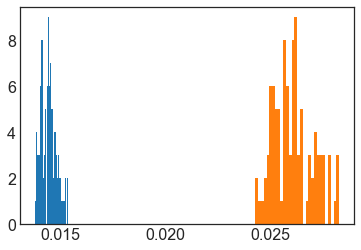

In [19]:
plt.hist(corr1k05['dA1'],bins=30)
plt.hist(corr1k05['da1'],bins=30)

(array([ 2.,  0.,  1.,  0.,  1.,  1.,  3.,  1.,  3.,  2.,  1.,  2.,  8.,
         6.,  3.,  9., 10.,  9.,  4., 12.,  2.,  5.,  5.,  2.,  2.,  3.,
         0.,  1.,  0.,  2.]),
 array([0.00515123, 0.00517415, 0.00519707, 0.00521999, 0.0052429 ,
        0.00526582, 0.00528874, 0.00531166, 0.00533457, 0.00535749,
        0.00538041, 0.00540333, 0.00542624, 0.00544916, 0.00547208,
        0.00549499, 0.00551791, 0.00554083, 0.00556375, 0.00558666,
        0.00560958, 0.0056325 , 0.00565542, 0.00567833, 0.00570125,
        0.00572417, 0.00574709, 0.00577   , 0.00579292, 0.00581584,
        0.00583876]),
 <a list of 30 Patch objects>)

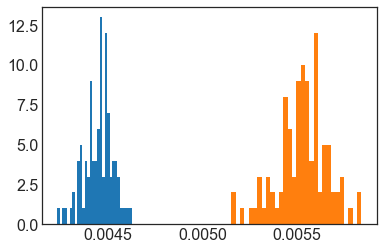

In [20]:
plt.hist(corr1k05['dA2'],bins=30)
plt.hist(corr1k05['da2'],bins=30)

In [21]:
print(corr1k05['A1'].std()/corr1k05['dA1'].mean())
print(corr1k05['A2'].std()/corr1k05['dA2'].mean())
print(corr1k05['D'].std()/corr1k05['dD'].mean())
print(corr1k05['dA1dA2'].mean()/corr1k05['da1da2'].mean())
print(corr1k05['dA1dD'].mean()/corr1k05['da1dd'].mean())
print(corr1k05['dA2dD'].mean()/corr1k05['dasdd'].mean())

1.6513868413309085
1.2394089460255016
1.0289935038219995
124.23276589869873
7.5744032967594075
3.1109776929357507


(array([ 1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  4.,  3.,  5.,  3.,  8.,
         4.,  7.,  5.,  6.,  6.,  7., 11., 11.,  3.,  2.,  4.,  2.,  2.,
         2.,  1.,  0.,  2.]),
 array([-1.16057002e-05, -1.09136520e-05, -1.02216038e-05, -9.52955562e-06,
        -8.83750743e-06, -8.14545923e-06, -7.45341104e-06, -6.76136284e-06,
        -6.06931465e-06, -5.37726645e-06, -4.68521826e-06, -3.99317006e-06,
        -3.30112187e-06, -2.60907368e-06, -1.91702548e-06, -1.22497729e-06,
        -5.32929091e-07,  1.59119104e-07,  8.51167299e-07,  1.54321549e-06,
         2.23526369e-06,  2.92731188e-06,  3.61936008e-06,  4.31140827e-06,
         5.00345647e-06,  5.69550466e-06,  6.38755286e-06,  7.07960105e-06,
         7.77164925e-06,  8.46369744e-06,  9.15574564e-06]),
 <a list of 30 Patch objects>)

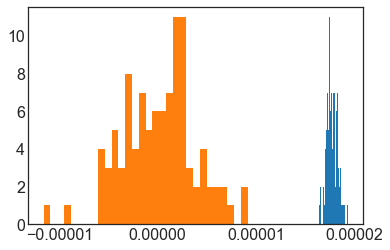

In [22]:
plt.hist(corr1k05['dA1dA2'],bins=30)
plt.hist(corr1k05['da1da2'],bins=30)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  3.,  2.,  2.,
         5.,  1.,  9.,  7., 12.,  5.,  6.,  4.,  9.,  4.,  7.,  6.,  5.,
         2.,  4.,  2.,  2.]),
 array([-1.63994611e-05, -1.48809108e-05, -1.33623605e-05, -1.18438101e-05,
        -1.03252598e-05, -8.80670951e-06, -7.28815920e-06, -5.76960888e-06,
        -4.25105857e-06, -2.73250825e-06, -1.21395794e-06,  3.04592379e-07,
         1.82314269e-06,  3.34169301e-06,  4.86024333e-06,  6.37879364e-06,
         7.89734396e-06,  9.41589427e-06,  1.09344446e-05,  1.24529949e-05,
         1.39715452e-05,  1.54900955e-05,  1.70086459e-05,  1.85271962e-05,
         2.00457465e-05,  2.15642968e-05,  2.30828471e-05,  2.46013974e-05,
         2.61199477e-05,  2.76384981e-05,  2.91570484e-05]),
 <a list of 30 Patch objects>)

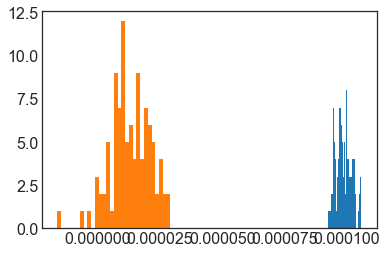

In [23]:
plt.hist(corr1k05['dA1dD'],bins=30)
plt.hist(corr1k05['da1dd'],bins=30)

(array([1., 0., 1., 0., 1., 2., 0., 2., 0., 5., 5., 9., 7., 9., 7., 7., 5.,
        4., 8., 5., 9., 3., 3., 3., 2., 0., 1., 0., 0., 1.]),
 array([3.02185658e-06, 3.28087507e-06, 3.53989356e-06, 3.79891204e-06,
        4.05793053e-06, 4.31694902e-06, 4.57596751e-06, 4.83498599e-06,
        5.09400448e-06, 5.35302297e-06, 5.61204146e-06, 5.87105994e-06,
        6.13007843e-06, 6.38909692e-06, 6.64811541e-06, 6.90713389e-06,
        7.16615238e-06, 7.42517087e-06, 7.68418936e-06, 7.94320784e-06,
        8.20222633e-06, 8.46124482e-06, 8.72026331e-06, 8.97928179e-06,
        9.23830028e-06, 9.49731877e-06, 9.75633725e-06, 1.00153557e-05,
        1.02743742e-05, 1.05333927e-05, 1.07924112e-05]),
 <a list of 30 Patch objects>)

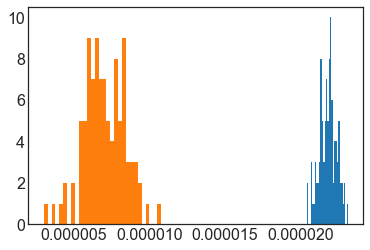

In [24]:
plt.hist(corr1k05['dA2dD'],bins=30)
plt.hist(corr1k05['dasdd'],bins=30)

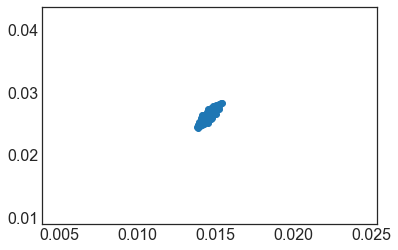

In [25]:
plt.scatter(corr1k05['dA1'],corr1k05['da1'])

Text(0, 0.5, 'dA2 ML')

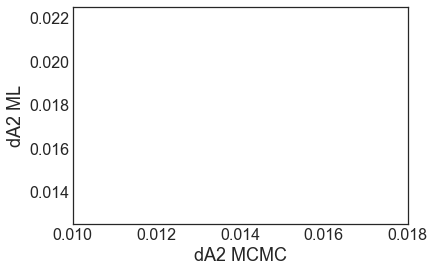

In [26]:
plt.scatter(corr1k05['dA2'],corr1k05['da2'])
plt.xlim((0.01,0.018))
plt.ylim((0.0125,0.0225))
plt.xlabel("dA2 MCMC")
plt.ylabel("dA2 ML")

In [27]:
corr1k05['dA2'].min()

0.00423056069691764